In [23]:
# Cell: Load raw_ic50.xlsx into `df`
from pathlib import Path
import os
import pandas as pd
import numpy as np

# try the expected filename first, otherwise pick the first .xlsx in the folder
p = Path('raw_ic50.xlsx')
if not p.exists():
    xls = list(Path('.').glob('*.xlsx'))
    if len(xls) == 0:
        raise FileNotFoundError(f"raw_ic50.xlsx not found and no .xlsx files present in {Path('.').resolve()}")
    # choose first candidate but warn
    p = xls[0]
    print(f"Warning: 'raw_ic50.xlsx' not found; using '{p.name}' instead.")

# read with openpyxl engine (recommended for .xlsx)
try:
    df = pd.read_excel(p, engine='openpyxl')
except Exception as e:
    raise RuntimeError(f"Failed to read Excel file {p}: {e}")

# normalize column names: strip whitespace and convert to string
df.columns = [str(c).strip() for c in df.columns]

print(f"Loaded '{p.name}' -> df with shape {df.shape}")
print('First 30 columns:')
print(df.columns.tolist()[:30])

# quick peek
try:
    display(df.head())
except Exception:
    print(df.head().to_string())

# note: if your time column or well names are different from expected, run `print(df.columns.tolist())` to inspect


Loaded 'raw_ic50.xlsx' -> df with shape (60, 69)
First 30 columns:
['Cycle Nr.', 'Time [s]', 'Temp. [°C]', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3']


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,E9,E10,E11,E12,F1,F2,F3,F4,F5,F6
0,1,0.000,25.2,0.5211,0.5210,0.5179,0.5503,0.5630,0.5761,NaN,...,NaN,NaN,NaN,NaN,0.4911,0.4763,0.4673,0.5229,0.5021,0.5244
1,2,60.012,24.9,0.5209,0.5209,0.5175,0.5505,0.5628,0.5748,NaN,...,NaN,NaN,NaN,NaN,0.4827,0.4676,0.4603,0.5163,0.4944,0.5183
2,3,120.039,24.8,0.5199,0.5208,0.5169,0.5501,0.5615,0.5742,NaN,...,NaN,NaN,NaN,NaN,0.4781,0.4622,0.4550,0.5111,0.4895,0.5141
3,4,180.057,24.9,0.5189,0.5198,0.5159,0.5497,0.5612,0.5735,NaN,...,NaN,NaN,NaN,NaN,0.4745,0.4582,0.4507,0.5067,0.4858,0.5119
4,5,240.068,24.8,0.5174,0.5182,0.5152,0.5497,0.5613,0.5730,NaN,...,NaN,NaN,NaN,NaN,0.4724,0.4547,0.4469,0.5027,0.4822,0.5067


In [24]:
# Build `signal_ts` (with - without) per concentration index and estimate propagated SEMs
import re
import numpy as np
import pandas as pd

# ensure df is present
if 'df' not in globals():
    try:
        df = pd.read_excel('raw_ic50.xlsx', engine='openpyxl')
        df.columns = [str(c).strip() for c in df.columns]
        print("Loaded df inside signal builder")
    except Exception as e:
        raise RuntimeError("`df` not found and failed to read raw_ic50.xlsx: " + str(e))

# detect well-like columns (e.g., A1, B3)
well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
if not well_cols:
    raise RuntimeError('No well-like columns found (expected names like A1, B3, ...).')

# parse row letter and column number
parsed = {c: re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups() for c in well_cols}
letters = sorted({v[0].upper() for v in parsed.values()})
colnums = sorted({int(v[1]) for v in parsed.values()})[:6]

# assign which letters are "with enzyme" vs "without enzyme" using the convention: first 3 letters = with, next 3 = without
with_rows = letters[:3]
without_rows = letters[3:6] if len(letters) >= 6 else letters[3:]

signal_ts = {}
signal_sem_ts = {}
for colnum in colnums:
    cols_for_num = [c for c,(r,n) in parsed.items() if int(n) == colnum]
    # try to pick the 'with' and 'without' columns by row membership
    with_cols = [c for c in cols_for_num if parsed[c][0].upper() in with_rows]
    without_cols = [c for c in cols_for_num if parsed[c][0].upper() in without_rows]
    # fallback: split the available columns in half if the letter mapping doesn't produce two groups
    if not with_cols or not without_cols:
        cols_sorted = sorted(cols_for_num)
        half = len(cols_sorted) // 2
        if half > 0:
            with_cols = cols_sorted[:half]
            without_cols = cols_sorted[half:]

    if with_cols and without_cols:
        wdf = df[with_cols].apply(pd.to_numeric, errors='coerce')
        bdf = df[without_cols].apply(pd.to_numeric, errors='coerce')
        mean_with = wdf.mean(axis=1).values
        mean_without = bdf.mean(axis=1).values
        signal = mean_with - mean_without
        # estimate SEM per timepoint for each group then propagate
        sem_with = wdf.std(axis=1, ddof=1) / np.sqrt(max(1, len(with_cols)))
        sem_without = bdf.std(axis=1, ddof=1) / np.sqrt(max(1, len(without_cols)))
        sem = np.sqrt(np.nan_to_num(sem_with)**2 + np.nan_to_num(sem_without)**2)
        signal_ts[colnum] = signal
        signal_sem_ts[colnum] = sem
    else:
        # couldn't form groups; fill with NaNs
        signal_ts[colnum] = np.full(len(df), np.nan)
        signal_sem_ts[colnum] = np.full(len(df), np.nan)

# define pair_concs using the same default mapping used elsewhere
default_concs_map = {1: 0.0, 2: 1.0, 3: 10.0, 4: 100.0, 5: 10_000.0, 6: 100_000.0}
pair_concs = np.array([default_concs_map.get(i, float(i)) for i in colnums])

print('Constructed signal_ts for column numbers:', colnums)
print('pair_concs:', pair_concs)
# provide a lightweight check
for k in list(signal_ts.keys()):
    print(f"col {k}: signal length={len(signal_ts[k])}, sem length={len(signal_sem_ts[k])}")

# make available at module globals
globals()['signal_ts'] = signal_ts
globals()['signal_sem_ts'] = signal_sem_ts
globals()['pair_concs'] = pair_concs


Constructed signal_ts for column numbers: [1, 2, 3, 4, 5, 6]
pair_concs: [0.e+00 1.e+00 1.e+01 1.e+02 1.e+04 1.e+05]
col 1: signal length=60, sem length=60
col 2: signal length=60, sem length=60
col 3: signal length=60, sem length=60
col 4: signal length=60, sem length=60
col 5: signal length=60, sem length=60
col 6: signal length=60, sem length=60


In [25]:
df

,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,E9,E10,E11,E12,F1,F2,F3,F4,F5,F6
0,1,0.000,25.2,0.5211,0.5210,0.5179,0.5503,0.5630,0.5761,NaN,...,NaN,NaN,NaN,NaN,0.4911,0.4763,0.4673,0.5229,0.5021,0.5244
1,2,60.012,24.9,0.5209,0.5209,0.5175,0.5505,0.5628,0.5748,NaN,...,NaN,NaN,NaN,NaN,0.4827,0.4676,0.4603,0.5163,0.4944,0.5183
2,3,120.039,24.8,0.5199,0.5208,0.5169,0.5501,0.5615,0.5742,NaN,...,NaN,NaN,NaN,NaN,0.4781,0.4622,0.4550,0.5111,0.4895,0.5141
3,4,180.057,24.9,0.5189,0.5198,0.5159,0.5497,0.5612,0.5735,NaN,...,NaN,NaN,NaN,NaN,0.4745,0.4582,0.4507,0.5067,0.4858,0.5119
4,5,240.068,24.8,0.5174,0.5182,0.5152,0.5497,0.5613,0.5730,NaN,...,NaN,NaN,NaN,NaN,0.4724,0.4547,0.4469,0.5027,0.4822,0.5067
5,6,300.078,24.7,0.5162,0.5168,0.5138,0.5496,0.5608,0.5729,NaN,...,NaN,NaN,NaN,NaN,0.4702,0.4509,0.4438,0.4997,0.4787,0.5057
6,7,360.092,24.7,0.5158,0.5155,0.5120,0.5491,0.5609,0.5731,NaN,...,NaN,NaN,NaN,NaN,0.4679,0.4479,0.4412,0.4978,0.4770,0.5057
7,8,420.102,24.6,0.5144,0.5145,0.5108,0.5485,0.5610,0.5736,NaN,...,NaN,NaN,NaN,NaN,0.4649,0.4454,0.4395,0.4970,0.4760,0.5005
8,9,480.114,24.7,0.5141,0.5134,0.5097,0.5484,0.5612,0.5749,NaN,...,NaN,NaN,NaN,NaN,0.4626,0.4438,0.4383,0.4967,0.4766,0.5012
9,10,540.127,24.7,0.5141,0.5128,0.5090,0.5492,0.5624,0.5773,NaN,...,NaN,NaN,NaN,NaN,0.4623,0.4440,0.4387,0.4965,0.4768,0.5026


In [26]:
# Create grouped DataFrame: averages and stddevs for A1-A3, A4-A6, B1-B3, B4-B6, ...
import re
import pandas as pd
import numpy as np

# assume `df` is loaded in the notebook (as in previous cells)
if 'df' not in globals():
    try:
        df = pd.read_excel('raw_ic50.xlsx')
    except Exception as e:
        raise RuntimeError('`df` not found in namespace and failed to read raw_ic50.xlsx: ' + str(e))

# keep any time column if present
time_col = None
for c in df.columns:
    if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
        time_col = c
        break

# identify well-like columns (e.g., A1, B3)
well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
if not well_cols:
    raise RuntimeError('No well-like columns found (expected names like A1, B3, ...).')

# collect unique row letters present
parsed = [(c, re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups()) for c in well_cols]
letters = sorted({p[1][0].upper() for p in parsed})

# groups: 1-3 and 4-6
group_ranges = [(1,3),(4,6)]

# build grouped dataframe
grouped = {}
for letter in letters:
    for start, end in group_ranges:
        cols = [f"{letter}{i}" for i in range(start, end+1) if f"{letter}{i}" in df.columns]
        if not cols:
            # skip missing groups
            continue
        mean_col = df[cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)
        std_col = df[cols].apply(pd.to_numeric, errors='coerce').std(axis=1, ddof=1)
        key_mean = f"{letter}_{start}-{end}_mean"
        key_std = f"{letter}_{start}-{end}_std"
        grouped[key_mean] = mean_col
        grouped[key_std] = std_col

# assemble into DataFrame
df_grouped = pd.DataFrame(grouped)
if time_col is not None:
    df_grouped.insert(0, str(time_col), df[time_col].values)

print('Created df_grouped with columns:')
print(df_grouped.columns.tolist())
print('\nFirst 5 rows:')
print(df_grouped.head())

# df_grouped is now available for downstream analysis/plotting


Created df_grouped with columns:
['Time [s]', 'A_1-3_mean', 'A_1-3_std', 'A_4-6_mean', 'A_4-6_std', 'B_1-3_mean', 'B_1-3_std', 'B_4-6_mean', 'B_4-6_std', 'C_1-3_mean', 'C_1-3_std', 'C_4-6_mean', 'C_4-6_std', 'D_1-3_mean', 'D_1-3_std', 'D_4-6_mean', 'D_4-6_std', 'E_1-3_mean', 'E_1-3_std', 'E_4-6_mean', 'E_4-6_std', 'F_1-3_mean', 'F_1-3_std', 'F_4-6_mean', 'F_4-6_std']

First 5 rows:
   Time [s]  A_1-3_mean  A_1-3_std  A_4-6_mean  A_4-6_std  B_1-3_mean  \
0     0.000    0.520000   0.001819    0.563133   0.012901    0.525567   
1    60.012    0.519767   0.001963    0.562700   0.012150    0.525067   
2   120.039    0.519200   0.002042    0.561933   0.012056    0.524467   
3   180.057    0.518200   0.002042    0.561467   0.011902    0.523033   
4   240.068    0.516933   0.001553    0.561333   0.011650    0.521067   

   B_1-3_std  B_4-6_mean  B_4-6_std  C_1-3_mean  ...  D_4-6_mean  D_4-6_std  \
0   0.004285    0.543600   0.007314    0.513167  ...    0.552133   0.019562   
1   0.004186    0.

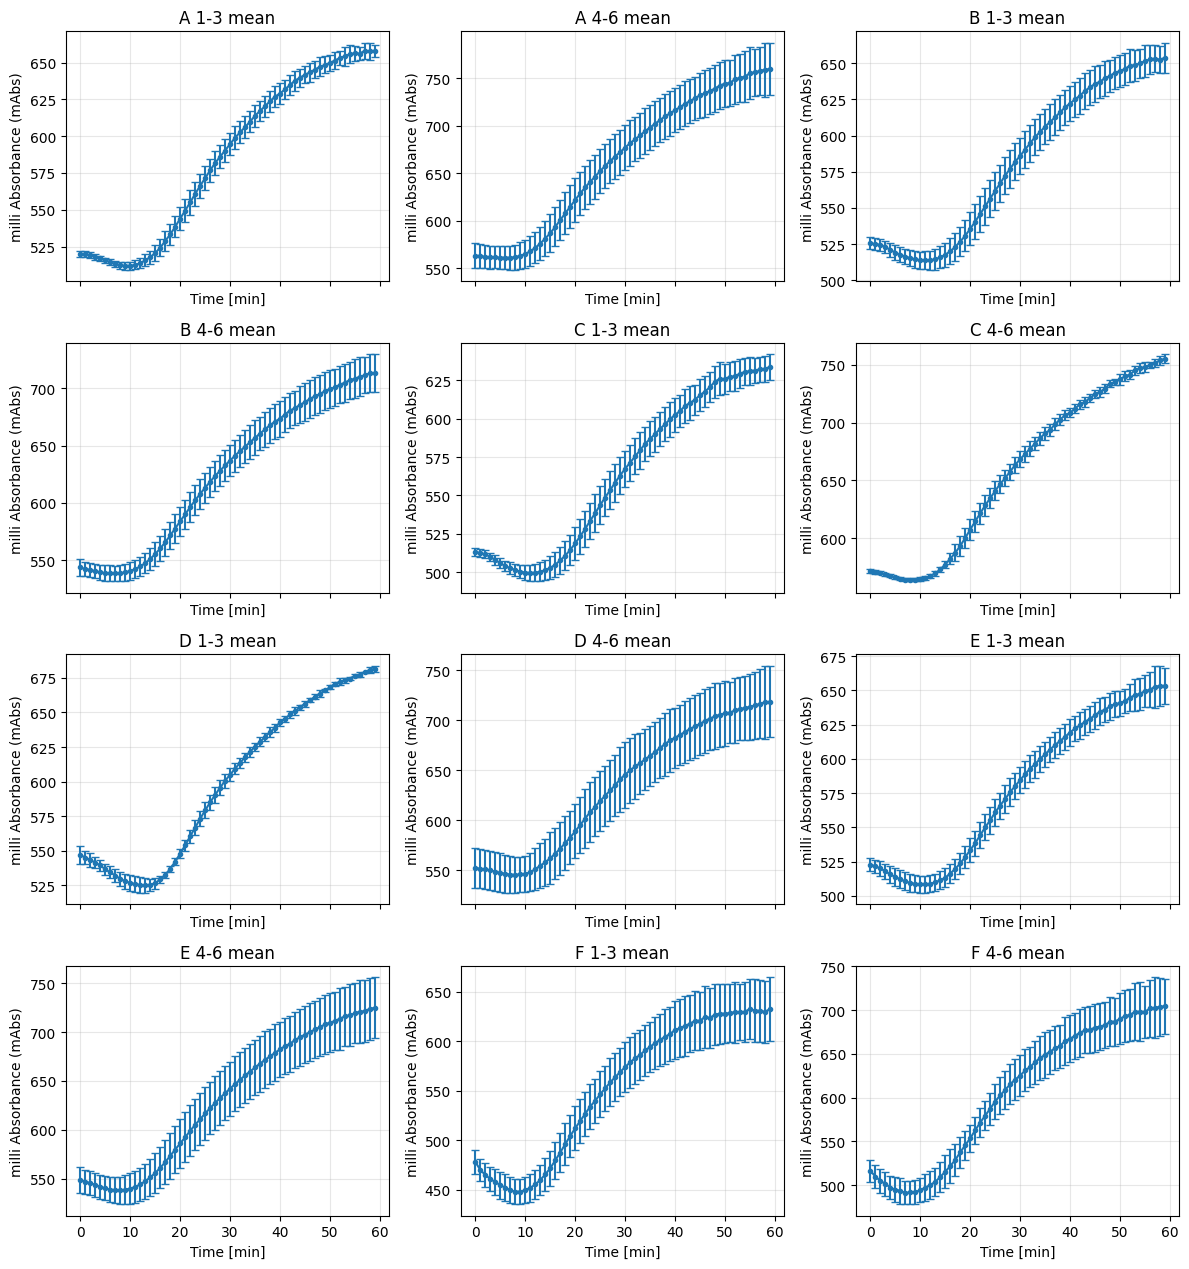

Plotted grouped mean panels for: ['A_1-3_mean', 'A_4-6_mean', 'B_1-3_mean', 'B_4-6_mean', 'C_1-3_mean', 'C_4-6_mean', 'D_1-3_mean', 'D_4-6_mean', 'E_1-3_mean', 'E_4-6_mean', 'F_1-3_mean', 'F_4-6_mean']


In [27]:
# Plot panel of grouped means with error bars
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure df_grouped exists
if 'df_grouped' not in globals():
    raise RuntimeError("`df_grouped` not found in the notebook namespace. Run the cell that creates 'df_grouped' first.")

# Detect time column if present
time_col = None
for c in df_grouped.columns:
    if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
        time_col = c
        break

mean_cols = [c for c in df_grouped.columns if c.endswith('_mean')]
mean_cols = sorted(mean_cols)
if not mean_cols:
    raise RuntimeError('No grouped "_mean" columns found in df_grouped.')

# Map mean -> std column
std_map = {}
for m in mean_cols:
    std_name = m.replace('_mean', '_std')
    if std_name in df_grouped.columns:
        std_map[m] = std_name
    else:
        std_map[m] = None

n = len(mean_cols)
cols = 3
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3.2), sharex=True)
axes = axes.flatten()

# Convert time to minutes if available
if time_col is not None:
    x = pd.to_numeric(df_grouped[time_col], errors='coerce').values / 60.0
else:
    x = np.arange(len(df_grouped))

for i, m in enumerate(mean_cols):
    ax = axes[i]
    y = pd.to_numeric(df_grouped[m], errors='coerce').values
    stdcol = std_map[m]
    yerr = pd.to_numeric(df_grouped[stdcol], errors='coerce').values if stdcol is not None else None
    # plot in milli-Abs (mAbs): scale values and errors by 1000
    y_plot = np.array(y, dtype=float) * 1000
    yerr_plot = (np.array(yerr, dtype=float) * 1000) if yerr is not None else None
    if yerr_plot is None:
        ax.plot(x, y_plot, '-o', ms=3)
    else:
        ax.errorbar(x, y_plot, yerr=yerr_plot, fmt='-o', ms=3, capsize=3)
    ax.set_title(m.replace('_', ' '))
    ax.set_xlabel('Time [min]' if time_col is not None else 'Index')
    ax.set_ylabel('milli Absorbance (mAbs)')
    ax.grid(alpha=0.3)

# hide any extra axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print('Plotted grouped mean panels for:', mean_cols)


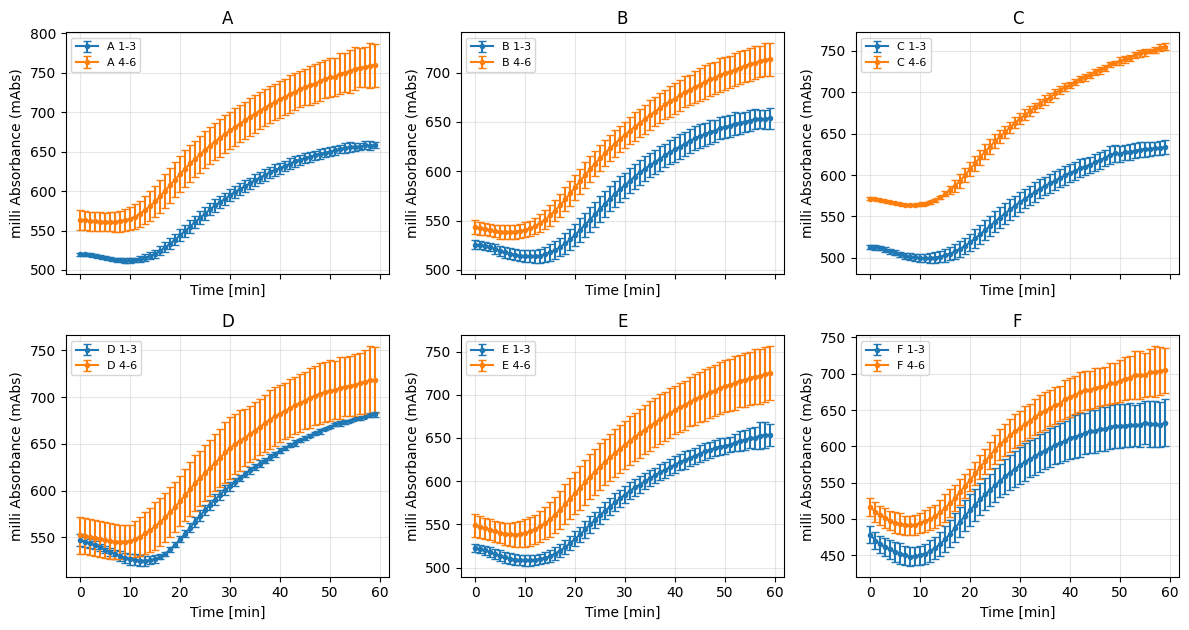

Plotted paired groups per letter (1-3 vs 4-6).


In [28]:
# Panel: compare A1-A3 vs A4-A6, B1-B3 vs B4-B6, etc. on the same subplot
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure df or df_grouped exists
if 'df' not in globals():
    try:
        df = pd.read_excel('raw_ic50.xlsx')
    except Exception as e:
        raise RuntimeError('`df` not found and failed to read raw_ic50.xlsx: ' + str(e))

# Prefer df_grouped if present
if 'df_grouped' in globals():
    grouped = df_grouped.copy()
    # detect time column
    time_col = None
    for c in grouped.columns:
        if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
            time_col = c
            break
    # convert to minutes if present
    if time_col is not None:
        x = pd.to_numeric(grouped[time_col], errors='coerce').values / 60.0
    else:
        x = np.arange(len(grouped))
    # find mean and std columns by pattern
    mean_cols = [c for c in grouped.columns if c.endswith('_mean')]
    letters = sorted({c.split('_')[0] for c in mean_cols})
    # helper to get columns
    def mean_col(letter, r):
        key = f"{letter}_{r[0]}-{r[1]}_mean"
        return key if key in grouped.columns else None
    def std_col(letter, r):
        key = f"{letter}_{r[0]}-{r[1]}_std"
        return key if key in grouped.columns else None
else:
    # create grouped on the fly from df (like earlier cell)
    time_col = None
    for c in df.columns:
        if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
            time_col = c
            break
    x = pd.to_numeric(df[time_col], errors='coerce').values / 60.0 if time_col is not None else np.arange(len(df))
    well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
    if not well_cols:
        raise RuntimeError('No well-like columns found to build groups.')
    parsed = [(c, re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups()) for c in well_cols]
    letters = sorted({p[1][0].upper() for p in parsed})
    # compute per-letter groups
    grouped = pd.DataFrame({})
    for letter in letters:
        for start, end in ((1,3),(4,6)):
            cols = [f"{letter}{i}" for i in range(start, end+1) if f"{letter}{i}" in df.columns]
            if not cols:
                continue
            grouped[f"{letter}_{start}-{end}_mean"] = df[cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)
            grouped[f"{letter}_{start}-{end}_std"] = df[cols].apply(pd.to_numeric, errors='coerce').std(axis=1, ddof=1)

# Now plot: one subplot per letter showing both groups (1-3 and 4-6) with error bars
groups = [(1,3),(4,6)]
n = len(letters)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3.2), sharex=True)
axes = axes.flatten()
for i, letter in enumerate(letters):
    ax = axes[i]
    plotted = False
    for (start,end), color, label_suffix in zip(groups, ['tab:blue','tab:orange'], ['1-3','4-6']):
        mcol = f"{letter}_{start}-{end}_mean"
        scol = f"{letter}_{start}-{end}_std"
        if mcol in grouped.columns:
            y = pd.to_numeric(grouped[mcol], errors='coerce').values
            yerr = pd.to_numeric(grouped[scol], errors='coerce').values if scol in grouped.columns else None
            # scale to milli-Abs
            y_plot = np.array(y, dtype=float) * 1000
            yerr_plot = (np.array(yerr, dtype=float) * 1000) if yerr is not None else None
            if yerr_plot is None:
                ax.plot(x, y_plot, '-o', ms=3, label=f'{letter} {label_suffix}', color=color)
            else:
                ax.errorbar(x, y_plot, yerr=yerr_plot, fmt='-o', ms=3, capsize=3, label=f'{letter} {label_suffix}', color=color)
            plotted = True
    if not plotted:
        ax.text(0.5,0.5,'no data', ha='center', va='center')
    ax.set_title(letter)
    ax.set_xlabel('Time [min]' if time_col is not None else 'Index')
    ax.set_ylabel('milli Absorbance (mAbs)')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)
# hide extra axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

print('Plotted paired groups per letter (1-3 vs 4-6).')


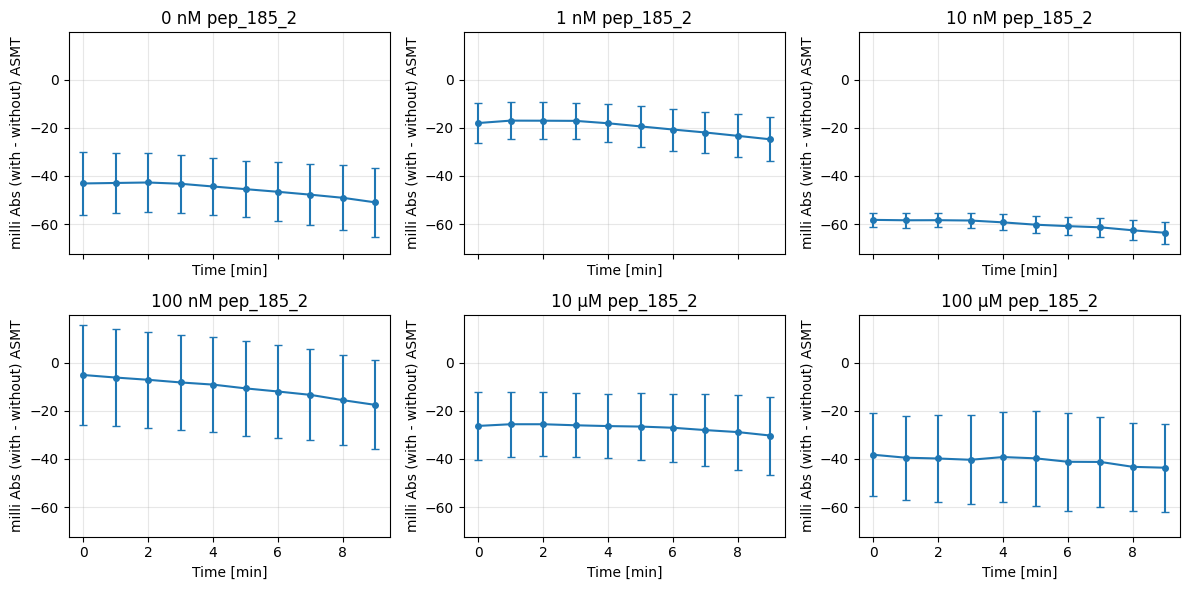

Plotted first 10 timepoints per letter (A->0 nM mapping) with shared Y limits.


In [29]:
# Plot: first 10 timepoints per letter, mapping A->0 nM, B->1 nM, C->10 nM, D->100 nM, E->10 uM, F->100 uM
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure df is present
if 'df' not in globals():
    try:
        df = pd.read_excel('raw_ic50.xlsx')
    except Exception as e:
        raise RuntimeError("`df` not found and failed to read raw_ic50.xlsx: " + str(e))

# detect time column
time_col = None
for c in df.columns:
    if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
        time_col = c
        break

# build grouped (prefer existing df_grouped)
if 'df_grouped' in globals():
    grouped = df_grouped.copy()
    if time_col is None:
        # try detect in grouped
        for c in grouped.columns:
            if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
                time_col = c
                break
else:
    # create grouped from df (per-letter 1-3 and 4-6 means/std)
    well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
    if not well_cols:
        raise RuntimeError('No well-like columns found to build groups for first-10-timepoints plot.')
    parsed = [(c, re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups()) for c in well_cols]
    letters = sorted({p[1][0].upper() for p in parsed})
    grouped = pd.DataFrame()
    for letter in letters:
        for start, end in ((1,3),(4,6)):
            cols = [f"{letter}{i}" for i in range(start, end+1) if f"{letter}{i}" in df.columns]
            if not cols:
                continue
            grouped[f"{letter}_{start}-{end}_mean"] = df[cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)
            grouped[f"{letter}_{start}-{end}_std"] = df[cols].apply(pd.to_numeric, errors='coerce').std(axis=1, ddof=1)
    if time_col is not None:
        grouped.insert(0, str(time_col), df[time_col].values)

# determine letters present in grouped
mean_cols = [c for c in grouped.columns if c.endswith('_mean')]
letters = sorted({c.split('_')[0] for c in mean_cols})
if not letters:
    raise RuntimeError('No letter groups found in grouped data for plotting.')

# mapping letters -> concentrations (nM). E and F are given in nM (10 µM = 10_000 nM)
letter_to_conc = {'A': 0.0, 'B': 1.0, 'C': 10.0, 'D': 100.0, 'E': 10_000.0, 'F': 100_000.0}

# subset first 10 timepoints
n_points = 10
if time_col is not None:
    x_all = pd.to_numeric(grouped[time_col], errors='coerce').values / 60.0
    x = x_all[:n_points]
else:
    x = np.arange(n_points)

# Prepare to compute global y-limits across all series (ignore NaNs)
y_vals = []
for letter in letters:
    mean1_key = f"{letter}_1-3_mean"
    mean2_key = f"{letter}_4-6_mean"
    std1_key = f"{letter}_1-3_std"
    std2_key = f"{letter}_4-6_std"

    if mean1_key in grouped.columns and mean2_key in grouped.columns:
        y1 = pd.to_numeric(grouped[mean1_key], errors='coerce').values[:n_points]
        y2 = pd.to_numeric(grouped[mean2_key], errors='coerce').values[:n_points]
        y = y1 - y2
        if std1_key in grouped.columns and std2_key in grouped.columns:
            s1 = pd.to_numeric(grouped[std1_key], errors='coerce').values[:n_points]
            s2 = pd.to_numeric(grouped[std2_key], errors='coerce').values[:n_points]
            y_lower = y - np.sqrt(np.nan_to_num(s1)**2 + np.nan_to_num(s2)**2)
            y_upper = y + np.sqrt(np.nan_to_num(s1)**2 + np.nan_to_num(s2)**2)
            y_vals.append(y_lower * 1000)
            y_vals.append(y_upper * 1000)
        else:
            y_vals.append((y * 1000))
    elif mean1_key in grouped.columns:
        y = pd.to_numeric(grouped[mean1_key], errors='coerce').values[:n_points]
        if std1_key in grouped.columns:
            s = pd.to_numeric(grouped[std1_key], errors='coerce').values[:n_points]
            y_vals.append((y - s) * 1000)
            y_vals.append((y + s) * 1000)
        else:
            y_vals.append(y * 1000)
    elif mean2_key in grouped.columns:
        y = -pd.to_numeric(grouped[mean2_key], errors='coerce').values[:n_points]
        if std2_key in grouped.columns:
            s = pd.to_numeric(grouped[std2_key], errors='coerce').values[:n_points]
            y_vals.append((y - s) * 1000)
            y_vals.append((y + s) * 1000)
        else:
            y_vals.append(y * 1000)

# flatten and compute min/max
if y_vals:
    all_y = np.concatenate([np.asarray(a).ravel() for a in y_vals])
    all_y = all_y[~np.isnan(all_y)]
    if all_y.size == 0:
        ymin, ymax = -0.1, 1.0
    else:
        ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
        # add small padding
        span = ymax - ymin
        if span == 0:
            pad = abs(ymax) * 0.05 if ymax != 0 else 0.1
        else:
            pad = span * 0.05
        ymin -= pad
        ymax += pad
else:
    ymin, ymax = -0.1, 1.0

# prepare plotting grid (2x3)
import math
n = len(letters)
cols = 3
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=True)
axes = np.array(axes).reshape(-1)

for i, letter in enumerate(letters):
    ax = axes[i]
    mean1_key = f"{letter}_1-3_mean"
    mean2_key = f"{letter}_4-6_mean"
    std1_key = f"{letter}_1-3_std"
    std2_key = f"{letter}_4-6_std"

    y = None
    yerr = None
    plotted = False

    if mean1_key in grouped.columns and mean2_key in grouped.columns:
        y1 = pd.to_numeric(grouped[mean1_key], errors='coerce').values[:n_points]
        y2 = pd.to_numeric(grouped[mean2_key], errors='coerce').values[:n_points]
        y = y1 - y2
        # use propagated std if available
        if std1_key in grouped.columns and std2_key in grouped.columns:
            s1 = pd.to_numeric(grouped[std1_key], errors='coerce').values[:n_points]
            s2 = pd.to_numeric(grouped[std2_key], errors='coerce').values[:n_points]
            # approximate propagated std (not SEM)
            yerr = np.sqrt(np.nan_to_num(s1)**2 + np.nan_to_num(s2)**2)
    elif mean1_key in grouped.columns:
        y = pd.to_numeric(grouped[mean1_key], errors='coerce').values[:n_points]
        yerr = pd.to_numeric(grouped[std1_key], errors='coerce').values[:n_points] if std1_key in grouped.columns else None
    elif mean2_key in grouped.columns:
        y = -pd.to_numeric(grouped[mean2_key], errors='coerce').values[:n_points]
        yerr = pd.to_numeric(grouped[std2_key], errors='coerce').values[:n_points] if std2_key in grouped.columns else None

    if y is not None:
        # scale to milli-Abs for plotting
        y_plot = np.array(y, dtype=float) * 1000
        yerr_plot = (np.array(yerr, dtype=float) * 1000) if yerr is not None else None
        if yerr_plot is None:
            ax.plot(x, y_plot, '-o', ms=4)
        else:
            ax.errorbar(x, y_plot, yerr=yerr_plot, fmt='-o', ms=4, capsize=3)
        plotted = True

    if not plotted:
        ax.text(0.5, 0.5, 'no data', ha='center', va='center')

    conc = letter_to_conc.get(letter, None)
    title = f"{letter}"
    if conc is not None:
        if conc >= 1000:
            # show µM if large
            title = f"{conc/1000:g} µM pep_185_2"
        else:
            title = f"{conc:g} nM pep_185_2"
    ax.set_title(title)
    ax.set_xlabel('Time [min]' if time_col is not None else 'Index')
    ax.set_ylabel('milli Abs (with - without) ASMT')
    ax.grid(alpha=0.3)
    # apply global y-limits so all panels share same interval
    ax.set_ylim(ymin, ymax)

# hide extra axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print(f'Plotted first {n_points} timepoints per letter (A->0 nM mapping) with shared Y limits.')


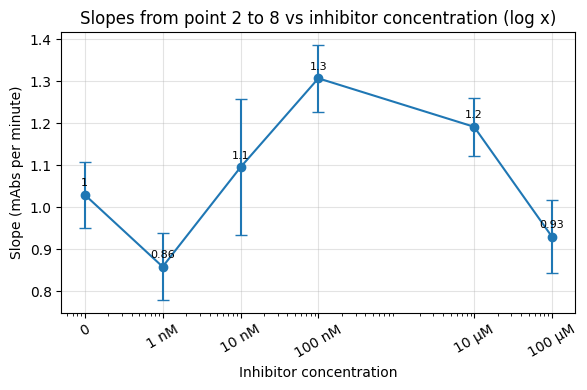

Concentrations (nM): [np.float64(0.0), np.float64(1.0), np.float64(10.0), np.float64(100.0), np.float64(10000.0), np.float64(100000.0)]
Slopes (mAbs per minute): [1.02952593 0.85813795 1.09499351 1.30683955 1.19138734 0.92954463]
Slope SE (mAbs per minute): [0.0791285  0.07946017 0.16145475 0.0791669  0.06904627 0.08673878]


In [30]:
# Compute slopes from point 2 to point 8 (1-based) and plot vs inhibitor concentration with error bars on log x-axis
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ensure df present
if 'df' not in globals():
    try:
        df = pd.read_excel('raw_ic50.xlsx')
    except Exception as e:
        raise RuntimeError("`df` not found and failed to read raw_ic50.xlsx: " + str(e))

# detect time column if present
time_col = None
for c in df.columns:
    if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
        time_col = c
        break

# Obtain time vector in minutes if present
if time_col is not None:
    time_vals = pd.to_numeric(df[time_col], errors='coerce').values / 60.0
else:
    time_vals = np.arange(len(df))

# identify well-like columns and concentration indices
well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
if not well_cols:
    raise RuntimeError('No well-like columns found to compute slopes.')
parsed = {c: re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups() for c in well_cols}
colnums = sorted({int(v[1]) for v in parsed.values()})[:6]
# default mapping (nM)
default_concs_map = {1: 0.0, 2: 1.0, 3: 10.0, 4: 100.0, 5: 10_000.0, 6: 100_000.0}
pair_concs = np.array([default_concs_map.get(i, float(i)) for i in colnums])

# Prepare signal per concentration: prefer existing signal_ts if available
signal_ts_local = {}
if 'signal_ts' in globals():
    for cnum in colnums:
        if cnum in globals().get('signal_ts', {}):
            arr = np.asarray(signal_ts[cnum])
            signal_ts_local[cnum] = arr

# if some concentrations missing in signal_ts_local, compute from df by splitting per-letter groups (1-3 vs 4-6)
missing = [c for c in colnums if c not in signal_ts_local]
if missing:
    letters = sorted({v[0].upper() for v in parsed.values()})
    with_rows = letters[:3]
    without_rows = letters[3:6] if len(letters) >= 6 else letters[3:]
    for colnum in missing:
        cols_for_num = [c for c,(r,n) in parsed.items() if int(n) == colnum]
        with_cols = [c for c in cols_for_num if parsed[c][0].upper() in with_rows]
        without_cols = [c for c in cols_for_num if parsed[c][0].upper() in without_rows]
        if not with_cols or not without_cols:
            cols_for_num_sorted = sorted(cols_for_num)
            half = len(cols_for_num_sorted)//2
            if half > 0:
                with_cols = cols_for_num_sorted[:half]
                without_cols = cols_for_num_sorted[half:]
        if with_cols and without_cols:
            wdf = df[with_cols].apply(pd.to_numeric, errors='coerce')
            bdf = df[without_cols].apply(pd.to_numeric, errors='coerce')
            mean_with = wdf.mean(axis=1).values
            mean_without = bdf.mean(axis=1).values
            signal_ts_local[colnum] = mean_with - mean_without
        else:
            signal_ts_local[colnum] = np.full(len(df), np.nan)

# Compute slopes between points 2..8 (inclusive, 1-based -> indices 1..7) and slope SE
start_pt = 2
end_pt = 8
s0 = start_pt - 1
s1 = end_pt - 1
slopes = []
slopes_se = []
for cnum in colnums:
    s = np.asarray(signal_ts_local.get(cnum, np.full(len(df), np.nan)))
    y = s[s0:s1+1]
    x = time_vals[s0:s1+1]
    mask = ~np.isnan(y) & ~np.isnan(x)
    if mask.sum() < 2:
        slopes.append(np.nan)
        slopes_se.append(np.nan)
        continue
    x_fit = x[mask].astype(float)
    y_fit = y[mask].astype(float)
    if np.allclose(x_fit, x_fit[0]):
        x_fit = np.arange(len(x_fit)).astype(float)
    n = len(x_fit)
    # linear fit
    try:
        m, b = np.polyfit(x_fit, y_fit, 1)
        # compute standard error of slope
        if n > 2:
            y_pred = m * x_fit + b
            residuals = y_fit - y_pred
            s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
            denom = np.sum((x_fit - x_fit.mean())**2)
            if denom > 0:
                m_se = s_err / np.sqrt(denom)
            else:
                m_se = np.nan
        else:
            m_se = np.nan
        slopes.append(m)
        slopes_se.append(m_se)
    except Exception:
        slopes.append(np.nan)
        slopes_se.append(np.nan)

slopes = np.array(slopes)
slopes_se = np.array(slopes_se)

# scale slopes to milli-Abs for plotting and annotation (slopes are now per minute)
slopes_plot = slopes * 1000
slopes_se_plot = slopes_se * 1000

# Prepare x values for plotting on log scale; handle zeros by mapping them to a small positive value for plotting
pair_concs_plot = pair_concs.astype(float).copy()
if np.any(pair_concs_plot <= 0):
    pos = pair_concs_plot[pair_concs_plot > 0]
    if pos.size > 0:
        minpos = pos.min()
        pair_concs_plot[pair_concs_plot <= 0] = minpos / 10.0
    else:
        pair_concs_plot[pair_concs_plot <= 0] = 1e-6

# Plot with error bars and log x-axis
fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(pair_concs_plot, slopes_plot, yerr=slopes_se_plot, fmt='o-', capsize=4)
ax.set_xscale('log')
ax.set_xlabel('Inhibitor concentration')
ax.set_ylabel('Slope (mAbs per minute)')
ax.grid(alpha=0.35)
ax.set_title('Slopes from point 2 to 8 vs inhibitor concentration (log x)')

# set tick labels: show original values and mark zeros as '0'
xticks = pair_concs_plot
ax.set_xticks(xticks)
xticklabels = []
for c in pair_concs:
    if c == 0:
        xticklabels.append('0')
    elif c >= 1000:
        xticklabels.append(f'{c/1000:g} µM')
    else:
        # show integer if whole
        if float(c).is_integer():
            xticklabels.append(f'{int(c)} nM')
        else:
            xticklabels.append(f'{c:g} nM')
ax.set_xticklabels(xticklabels, rotation=30)

# annotate slope values
for x_val_plot, slope_val, se_val, orig_c in zip(pair_concs_plot, slopes_plot, slopes_se_plot, pair_concs):
    if not np.isnan(slope_val):
        ax.annotate(f'{slope_val:.2g}', (x_val_plot, slope_val), textcoords='offset points', xytext=(0,6), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print('Concentrations (nM):', list(pair_concs))
print('Slopes (mAbs per minute):', slopes_plot)
print('Slope SE (mAbs per minute):', slopes_se_plot)


Pairwise p-values (two-sided Welch style):
           0    1nM   10nM  100nM   10uM  100uM
0      1.000  0.157  0.726  0.033  0.155  0.415
1nM    0.157  1.000  0.228  0.003  0.010  0.557
10nM   0.726  0.228  1.000  0.276  0.601  0.394
100nM  0.033  0.003  0.276  1.000  0.298  0.009
10uM   0.155  0.010  0.601  0.298  1.000  0.041
100uM  0.415  0.557  0.394  0.009  0.041  1.000

Pairwise t-statistics:
           0    1nM   10nM  100nM   10uM  100uM
0      0.000  1.528 -0.364 -2.478 -1.541  0.852
1nM   -1.528  0.000 -1.316 -4.000 -3.166 -0.607
10nM   0.364  1.316  0.000 -1.178 -0.549  0.903
100nM  2.478  4.000  1.178  0.000  1.099  3.213
10uM   1.541  3.166  0.549 -1.099  0.000  2.362
100uM -0.852  0.607 -0.903 -3.213 -2.362  0.000

Reference for comparisons: 0 (index 0)

Comparisons vs reference:
        slope  slope_se  n  t_vs_ref  df_vs_ref  p_vs_ref
conc                                                     
1nM    0.8581    0.0795  7   -1.5283     9.9998    0.1574
10nM   1.0950    0.1

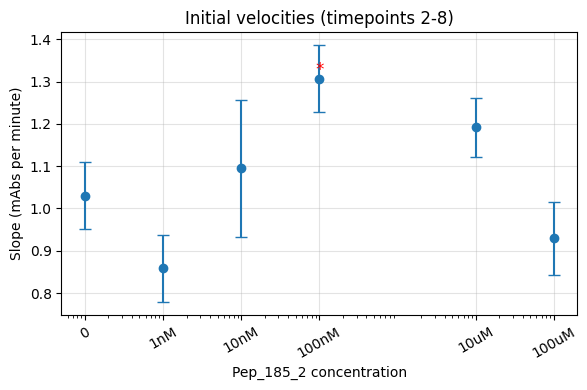


Done. Note: p-values are approximate; slopes are estimated from one time-series per concentration (n small). Use caution interpreting results.


In [31]:
# Estimate significance of differences between slopes (points 2..8)
# Recompute slopes, slope SE, and sample counts, then perform pairwise Welch t-tests.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t as tdist

# Ensure df present
if 'df' not in globals():
    try:
        df = pd.read_excel('raw_ic50.xlsx')
    except Exception as e:
        raise RuntimeError("`df` not found and failed to read raw_ic50.xlsx: " + str(e))

# detect time column if present
time_col = None
for c in df.columns:
    if str(c).strip().lower() in ('time [s]', 'time[s]', 'time', 'time_s'):
        time_col = c
        break
if time_col is not None:
    time_vals = pd.to_numeric(df[time_col], errors='coerce').values / 60.0
else:
    time_vals = np.arange(len(df))

# identify well-like columns
well_cols = [c for c in df.columns if re.match(r"^[A-Za-z]+\d+$", str(c).strip())]
if not well_cols:
    raise RuntimeError('No well-like columns found to compute slopes.')
parsed = {c: re.match(r"^([A-Za-z]+)(\d+)$", str(c).strip()).groups() for c in well_cols}
colnums = sorted({int(v[1]) for v in parsed.values()})[:6]
# concentration mapping
default_concs_map = {1: 0.0, 2: 1.0, 3: 10.0, 4: 100.0, 5: 10_000.0, 6: 100_000.0}
pair_concs = np.array([default_concs_map.get(i, float(i)) for i in colnums])

# build per-concentration signal (with - without) similar to previous cell
signal_ts_local = {}
letters = sorted({v[0].upper() for v in parsed.values()})
with_rows = letters[:3]
without_rows = letters[3:6] if len(letters) >= 6 else letters[3:]
for colnum in colnums:
    cols_for_num = [c for c,(r,n) in parsed.items() if int(n) == colnum]
    with_cols = [c for c in cols_for_num if parsed[c][0].upper() in with_rows]
    without_cols = [c for c in cols_for_num if parsed[c][0].upper() in without_rows]
    if not with_cols or not without_cols:
        cols_for_num_sorted = sorted(cols_for_num)
        half = len(cols_for_num_sorted)//2
        if half > 0:
            with_cols = cols_for_num_sorted[:half]
            without_cols = cols_for_num_sorted[half:]
    if with_cols and without_cols:
        wdf = df[with_cols].apply(pd.to_numeric, errors='coerce')
        bdf = df[without_cols].apply(pd.to_numeric, errors='coerce')
        mean_with = wdf.mean(axis=1).values
        mean_without = bdf.mean(axis=1).values
        signal_ts_local[colnum] = mean_with - mean_without
    else:
        signal_ts_local[colnum] = np.full(len(df), np.nan)

# slope window
start_pt = 2
end_pt = 8
s0 = start_pt - 1
s1 = end_pt - 1

slopes = []
slopes_se = []
ns = []
for cnum in colnums:
    s = np.asarray(signal_ts_local.get(cnum, np.full(len(df), np.nan)))
    y = s[s0:s1+1]
    x = time_vals[s0:s1+1]
    mask = ~np.isnan(y) & ~np.isnan(x)
    npts = mask.sum()
    ns.append(int(npts))
    if npts < 2:
        slopes.append(np.nan)
        slopes_se.append(np.nan)
        continue
    x_fit = x[mask].astype(float)
    y_fit = y[mask].astype(float)
    if np.allclose(x_fit, x_fit[0]):
        x_fit = np.arange(len(x_fit)).astype(float)
    n = len(x_fit)
    try:
        m, b = np.polyfit(x_fit, y_fit, 1)
        if n > 2:
            y_pred = m * x_fit + b
            residuals = y_fit - y_pred
            s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
            denom = np.sum((x_fit - x_fit.mean())**2)
            m_se = s_err / np.sqrt(denom) if denom > 0 else np.nan
        else:
            m_se = np.nan
        slopes.append(m)
        slopes_se.append(m_se)
    except Exception:
        slopes.append(np.nan)
        slopes_se.append(np.nan)

slopes = np.array(slopes)
slopes_se = np.array(slopes_se)
ns = np.array(ns)

# scale slopes and SE to milli-Abs for reporting and plotting (slopes are per minute)
slopes_mabs = slopes * 1000
slopes_se_mabs = slopes_se * 1000

# pairwise comparisons (Welch-type using slope SEs and df = n-2 for each slope)
nconc = len(colnums)
pvals = np.full((nconc, nconc), np.nan)
tstats = np.full((nconc, nconc), np.nan)
dfs = np.full((nconc, nconc), np.nan)
for i in range(nconc):
    for j in range(nconc):
        m1 = slopes[i]; se1 = slopes_se[i]; n1 = ns[i]
        m2 = slopes[j]; se2 = slopes_se[j]; n2 = ns[j]
        if np.isnan(m1) or np.isnan(m2) or np.isnan(se1) or np.isnan(se2):
            continue
        se_diff = np.sqrt(se1**2 + se2**2)
        if se_diff == 0 or np.isnan(se_diff):
            continue
        t = (m1 - m2) / se_diff
        # Welch-Satterthwaite df approximation using variances of slope estimates: var = se^2
        # df = (v1+v2)^2 / (v1^2/(n1-2) + v2^2/(n2-2)), where v1 = se1^2
        v1 = se1**2; v2 = se2**2
        denom = 0.0
        if (n1 - 2) > 0:
            denom += (v1**2) / (n1 - 2)
        if (n2 - 2) > 0:
            denom += (v2**2) / (n2 - 2)
        if denom > 0:
            df_approx = (v1 + v2)**2 / denom
        else:
            df_approx = np.nan
        p = 2 * tdist.sf(abs(t), df_approx) if not np.isnan(df_approx) else np.nan
        pvals[i, j] = p
        tstats[i, j] = t
        dfs[i, j] = df_approx

# assemble results into DataFrames with readable labels
def conc_label(c):
    if c == 0:
        return '0'
    if c >= 1000:
        return f'{c/1000:g}uM'
    return f'{int(c)}nM' if float(c).is_integer() else f'{c:g}nM'

labels = [conc_label(c) for c in pair_concs]
pval_df = pd.DataFrame(pvals, index=labels, columns=labels)
tstat_df = pd.DataFrame(tstats, index=labels, columns=labels)
df_df = pd.DataFrame(dfs, index=labels, columns=labels)

print('Pairwise p-values (two-sided Welch style):')
with pd.option_context('display.precision', 3):
    print(pval_df)

print('\nPairwise t-statistics:')
with pd.option_context('display.precision', 3):
    print(tstat_df)

# Also compare each concentration vs reference (A / 0 nM if present)
ref_idx = None
for idx, c in enumerate(pair_concs):
    if c == 0:
        ref_idx = idx
        break
if ref_idx is None:
    ref_idx = 0  # fallback to first concentration

ref_label = labels[ref_idx]
print(f"\nReference for comparisons: {ref_label} (index {ref_idx})")
comp_rows = []
for i, lab in enumerate(labels):
    if i == ref_idx:
        continue
    comp_rows.append({
        'conc': lab,
        'slope': slopes_mabs[i],
        'slope_se': slopes_se_mabs[i],
        'n': ns[i],
        't_vs_ref': tstats[i, ref_idx],
        'df_vs_ref': dfs[i, ref_idx],
        'p_vs_ref': pval_df.iloc[i, ref_idx]
    })
comp_df = pd.DataFrame(comp_rows).set_index('conc')
print('\nComparisons vs reference:')
with pd.option_context('display.precision', 4):
    print(comp_df)

# plot slopes with error bars and mark significance vs reference
fig, ax = plt.subplots(figsize=(6,4))
# plotting x-values using previous plotting mapping: map zeros to small positive value
pair_concs_plot = pair_concs.astype(float).copy()
if np.any(pair_concs_plot <= 0):
    pos = pair_concs_plot[pair_concs_plot > 0]
    pair_concs_plot[pair_concs_plot <= 0] = (pos.min()/10.0) if pos.size>0 else 1e-6
ax.errorbar(pair_concs_plot, slopes_mabs, yerr=slopes_se_mabs, fmt='o', capsize=4)
ax.set_xscale('log')
ax.set_xlabel('Pep_185_2 concentration')
ax.set_ylabel('Slope (mAbs per minute)')
ax.grid(alpha=0.35)
ax.set_title('Initial velocities (timepoints 2-8)')
# annotate significance vs ref
for xi, lab, pv, yv in zip(pair_concs_plot, labels, pval_df.iloc[:, ref_idx].values, slopes_mabs):
    if lab == ref_label:
        continue
    if np.isnan(pv):
        continue
    if pv < 0.001:
        sig = '***'
    elif pv < 0.01:
        sig = '**'
    elif pv < 0.05:
        sig = '*'
    else:
        sig = ''
    if sig:
        ax.text(xi, yv, sig, ha='center', va='bottom', fontsize=12, color='red')

# set x ticks and labels
ax.set_xticks(pair_concs_plot)
ax.set_xticklabels(labels, rotation=30)
plt.tight_layout()
plt.show()

print('\nDone. Note: p-values are approximate; slopes are estimated from one time-series per concentration (n small). Use caution interpreting results.')
